In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import binom, multinomial, dirichlet
import statsmodels.discrete.discrete_model as sm
from statsmodels.stats.contingency_tables import mcnemar                                                           

In [ ]:
output_dir =  os.path.join('..', 'output')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [2]:
def compute_power(prob_table, dataset_size, alpha=0.05, r=5000):

    if prob_table[0, 1] == prob_table[1, 0]:
        raise RuntimeError("Power is undefined when the true effect is zero.")

    pvals = []
    diffs = []
    for i in range(r):  # number of simulations
        sample = np.random.multinomial(n=dataset_size, pvals=prob_table.reshape((4,))).reshape((2,2))
        acc_diff = (sample[0,1] - sample[1, 0]) / dataset_size
        test_results = mcnemar(sample)
        pvals.append(test_results.pvalue)
        diffs.append(acc_diff)

    true_diff = prob_table[0, 1] - prob_table[1, 0]
    true_sign = np.sign(true_diff) 
    sig_diffs = [d for i, d in enumerate(diffs) if pvals[i] <= alpha]
    power = len([d for i, d in enumerate(diffs) if pvals[i] <= alpha and np.sign(d) == true_sign]) / r
    mean_effect = np.mean(diffs)
    type_m = np.mean(np.abs(sig_diffs) / np.abs(true_diff))
    type_s = np.mean(np.sign(sig_diffs) != true_sign)

    return power, mean_effect, type_m, type_s


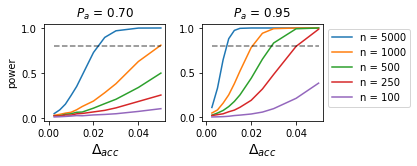

In [12]:
n_sim = 5000

n_vals = []
delta_acc_vals = []
agreement_vals = []
powers = []

agreement_rates = [0.7, 0.95]
markers = ['o', '^', 'v', 's', 'x']
use_markers = False

fig, axes = plt.subplots(ncols=len(agreement_rates), figsize=(2.5 * len(agreement_rates), 1.8), sharey=False, sharex=True)
plt.subplots_adjust(wspace=0.3)

for ax_i, agreement_rate in enumerate(agreement_rates):
    if agreement_rate > 0.95:
        delta_accs = [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02, 0.025, 0.03]
    else:
        delta_accs = [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05]
    for n_i, n in enumerate([5000, 1000, 500, 250, 100]):
        power_vals = []
        type_m_vals = []
        type_s_vals = []
        for delta_accuracy in delta_accs:
            p_disagree = 1.0 - agreement_rate
            base = p_disagree / 2
            p_a_better = base + delta_accuracy / 2
            p_b_better = base - delta_accuracy / 2
            table = np.array([[0, p_b_better], [p_a_better, agreement_rate]])
            assert table.sum() == 1.
                        
            power, mean_effect, type_m, type_s = compute_power(table, dataset_size=n, r=n_sim)            
            power_vals.append(power)
            type_m_vals.append(type_m)
            type_s_vals.append(type_s)
            
            n_vals.append(n)
            delta_acc_vals.append(delta_accuracy)
            agreement_vals.append(agreement_rate)
            powers.append(power)
            
        if agreement_rate > 0.95:            
            marker_indices = [2, 4, 6, 8]
        else:
            marker_indices = [2, 4, 6, 8, 9, 10]
        if use_markers:
            axes[ax_i].scatter([delta_accs[i] for i in marker_indices], [power_vals[i] for i in marker_indices], label='n = {:d}'.format(n), marker=markers[n_i], s=15) 
            axes[ax_i].plot(delta_accs, power_vals) 
        else:
            axes[ax_i].plot(delta_accs, power_vals, label='n = {:d}'.format(n)) 
            
    axes[ax_i].set_title('$P_a$ = {:.2f}'.format(agreement_rate))
    axes[ax_i].set_xlabel('$\Delta_{acc}$', fontsize=14)
    axes[ax_i].plot(delta_accs, np.ones_like(delta_accs)*0.8, 'k--', alpha=0.5, label=None)
    axes[ax_i].set_xlim(-0.002, 0.052)
    axes[ax_i].set_xticks([0., 0.02, 0.04])
    
axes[0].set_ylabel('power')
axes[-1].legend(loc='upper left', bbox_to_anchor=(1,1));
plt.savefig(os.path.join(output_dir, 'Figure03.pdf'), bbox_inches='tight')
plt.show();

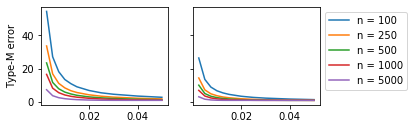

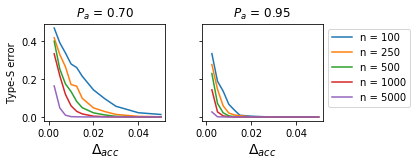

In [13]:
# Type-M and Type-S

n_sim = 30000

n_vals = []
delta_acc_vals = []
agreement_vals = []
powers = []

agreement_rates = [0.7, 0.95]
markers = ['o', '^', 'v', 's', 'x']

fig2, axes2 = plt.subplots(ncols=len(agreement_rates), figsize=(2.5 * len(agreement_rates), 1.8), sharey=True, sharex=True)
fig3, axes3 = plt.subplots(ncols=len(agreement_rates), figsize=(2.5 * len(agreement_rates), 1.8), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.3)

for ax_i, agreement_rate in enumerate(agreement_rates):
    if agreement_rate > 0.95:
        delta_accs = [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02, 0.025, 0.03]
    else:
        delta_accs = [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05]
    for n in [100, 250, 500, 1000, 5000]:
        power_vals = []
        type_m_vals = []
        type_s_vals = []
        for delta_accuracy in delta_accs:
            p_disagree = 1.0 - agreement_rate
            base = p_disagree / 2
            p_a_better = base + delta_accuracy / 2
            p_b_better = base - delta_accuracy / 2
            table = np.array([[0, p_b_better], [p_a_better, agreement_rate]])
            assert table.sum() == 1.
            
            power, mean_effect, type_m, type_s = compute_power(table, dataset_size=n, r=n_sim)            
            power_vals.append(power)
            type_m_vals.append(type_m)
            type_s_vals.append(type_s)
            
            n_vals.append(n)
            delta_acc_vals.append(delta_accuracy)
            agreement_vals.append(agreement_rate)
            powers.append(power)
            
        axes2[ax_i].plot(delta_accs, type_m_vals, label='n = {:d}'.format(n))
        axes3[ax_i].plot(delta_accs, type_s_vals, label='n = {:d}'.format(n))

    axes3[ax_i].set_title('$P_a$ = {:.2f}'.format(agreement_rate))
    axes3[ax_i].set_xlabel('$\Delta_{acc}$', fontsize=14)
    axes3[ax_i].set_xlim(-0.002, 0.052)
    axes3[ax_i].set_xticks([0., 0.02, 0.04])
    
axes2[0].set_ylabel('Type-M error')
axes2[-1].legend(loc='upper left', bbox_to_anchor=(1,1))

axes3[0].set_ylabel('Type-S error')
axes3[-1].legend(loc='upper left', bbox_to_anchor=(1,1))

